In [1]:
import numpy as np

In [333]:
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,34,450)
omwa = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwb = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]

#omwa.integrate(ts, pmw, method = 'leapfrog')
#omwb.integrate(ts, ps, method = 'leapfrog')

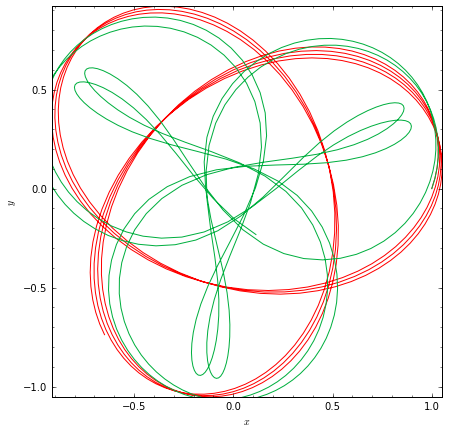

In [485]:
matplotlib.rcParams['figure.figsize'] = (7.0, 7.)
omwb.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')
omwa.plot(d1 = 'x', d2 = 'y', overplot = True, color = '#00AF3F')

In [551]:
ts = np.linspace(0,150,1200)
omwf = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwg = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwfd = Orbit(vxvv=[1,0.25001,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwf.integrate(ts, pmw, method = 'leapfrog')
omwfd.integrate(ts, pmw, method = 'leapfrog')
#omwg.integrate(ts, ps, method = 'leapfrog')

In [552]:
omwg.integrate(ts, ps, method = 'leapfrog')

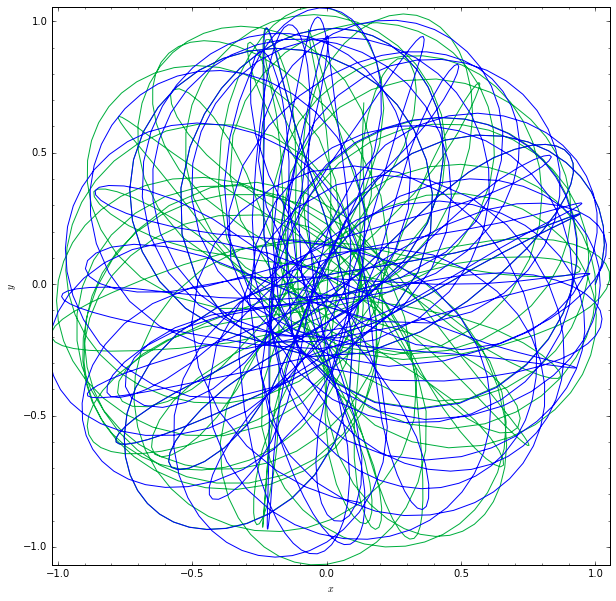

In [565]:
matplotlib.rcParams['figure.figsize'] = (10., 10.)
#omwg.plot('k.', d1 = 'R', d2 = 'vR', overplot = False, color = 'crimson')
omwf.plot('-', d1 = 'x', d2 = 'y', overplot = False, color = '#00AF3F')
omwfd.plot('-', d1 = 'x', d2 = 'y', overplot = True, color = 'blue')

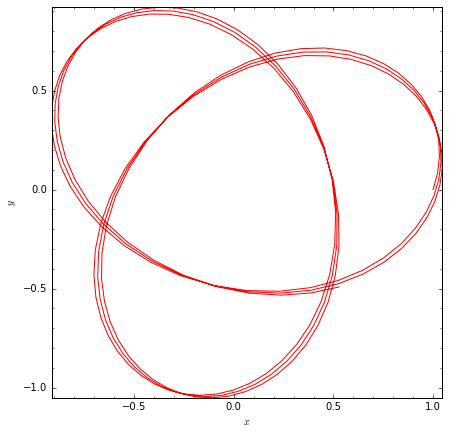

In [488]:
omwc = Orbit(vxvv=[1,0.25,0.7,0,0.0,0])
tsc = np.linspace(0,30,250)
omwc.integrate(tsc, ps, method = 'leapfrog')
omwc.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')

[ 1.0001  0.25    0.7     0.      0.      0.    ]


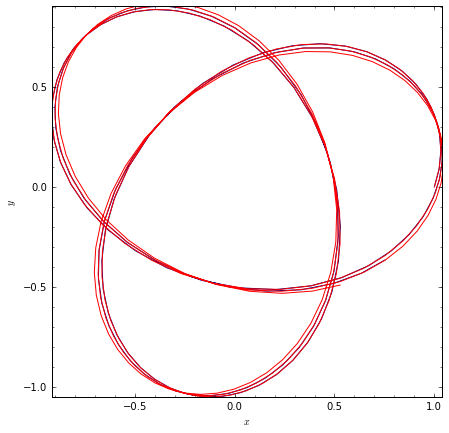

In [489]:
omwc.turn_physical_off()
icon = np.array([1.0001,0.25,0.7,0,0.0,0])
print(icon)
omwx = Orbit(vxvv=icon)
tsx = np.linspace(0,20,150)
omwx.integrate(tsx, ps, method = 'leapfrog')
omwx.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'navy')
omwc.plot(d1 = 'x', d2 = 'y', overplot = True, color = 'red')

In [451]:
aaa = np.array([[1,2],[3,4]])
print(aaa[:,1])
print(np.size(aaa))

[2 4]
4


In [527]:
pp = PP(normalize = True)
op = Orbit(vxvv = [1.,.4,.93, 0.])
tsp = np.linspace(0,10,200)
op.integrate(tsp, pp,method = 'leapfrog')

In [ ]:
matplotlib.rcParams['figure.figsize'] = (7.0, 7.)
op.plot(d1 = 'x', d2 = 'y', overplot = False)

# ==========================  GALI  =============================

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (7.0, 5.5)

from astropy import units
from galpy.orbit import Orbit
from FerrersPotential import FerrersPotential as FP
from galpy.potential import PlummerPotential as PP

In [266]:
""" #1
name: devolist
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    in other than first iteration also 'indev', a list which contains normalized deviation vectors from previous
    iteration to be applied to the current state of the Orbit
    WARNING: Due to the method of creating the deviation vectors none of the coordinates can be zero!
             Otherwise at least two of them are linearly dependent!
output:
    list of initial conditions for deviated orbit; devos
"""
def devolist(icon, indev=None):
    devos = [] 
    if indev == None:
        reldev = 0.001
        dorb = icon[:]
        #for i in range(len(icon)):
        for i in range(3):
            dorb = icon[:]
            dorb[i] += dorb[i]*reldev
            devos.append(dorb)
    else:
        for i in range(len(indev)):
            dorb = icon[:]
            dorb = list(np.array(devo)+np.array(indev[i]))
            devos.append(devo)
    return devos
# test
#print(vectlist([1,0.25,0.7,0,0.0,0]))#, indev = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,2,1,0,0,0]]))

In [267]:
""" #2
name: evolveorbit
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    final time; tf
    potential; pot
output:
    list of orbit parameters in time tf;
"""
x = []
y = []
def evolveorbit(icon, tf, pot):
    global x
    global y
    o = Orbit(vxvv=icon) # [R,vR,vT,z,vz,phi]
    ts = np.linspace(0.,tf,10)
    o.integrate(ts, pot, method = 'leapfrog')
    x.append(o.x(ts[-1]))
    y.append(o.y(ts[-1]))
    #return [o.R(tf),o.vR(tf),o.vT(tf),o.z(tf),o.vz(tf),o.phi(tf)] #for Ferrers potential
    return [o.R(ts[-1]),o.vR(ts[-1]),o.vT(ts[-1]),o.phi(ts[-1])]

In [268]:
""" #3
name: dvector
input:
    evolved orbit o and deviated orbit d
output:
    deviation vector w
"""
def dvector(o,d):
    return np.array(d)-np.array(o)

In [269]:
""" #4
name: matrixnorm
input:
    list of devitation vectors (np.arrays) to be normalized; wj
output:
    np.array of normalized deviation vectors; a
"""
def matrixnorm(wj):
    a = np.array(wj) # creates matrix consisting of k deviation vectors of dimension N
    k = len(a)
    for j in range(k):
        a[j] = abs(a[j] / np.linalg.norm(a[j]))
    return a

In [270]:
""" #5
name: galivalue
input:
    np.array of deviation vectors; a
output:
    value of gali at a specific time; g
"""
def galivalue(a):
    aT = np.transpose(a)
    s = np.linalg.svd(aT)[1] # creates array of singular values 
    return np.prod(s) # returns product of singular values ~ gali

# test:
#galivalue(a)

In [271]:
"""
name: gali
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
output:
    current value of gali, new IC for the Orbit, normalized dev. vectors in matrix for next step 
"""
def gali(o, tau, potential, w=None):
    if type(w) == type(None):
        v = devolist(list(o), indev = w) #deviated orbits from the Orbit
    else:
        v = w
    newo = evolveorbit(o, tau, potential) #evolves the Orbit
    wj = []
    for dorbit in v:
        temp = evolveorbit(dorbit + o*(type(w) != type(None)), tau, potential) #evolves the deviated orbits to time tau
        wj.append(dvector(o=newo,d=temp)) #creates list of deviation vectors in time tau
    a = matrixnorm(wj) #normalizes the matrix containing deviation vectors in time tau
    return galivalue(a), newo, np.array(wj), o,v #returns value of gali, new IC for the Orbit, x-normalized-x dev. vectors in matrix 

ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1,0.25,0.7,0.0,0.0,0.0])
test = gali(icon, 0.001, pp)
print(test)

(0.99999688153053212, [1.0002497449735441, 0.24948992002380666, 0.69982522216845588, 0.00069982516175137374], array([[  1.00000017e-03,   3.40067818e-07,   1.74440768e-07,
         -6.98951250e-07],
       [  2.49999974e-07,   2.49999920e-04,  -1.74912621e-07,
         -1.74665884e-10],
       [  4.90122609e-10,   9.80122799e-07,   6.99824879e-04,
          6.99825243e-07]]), array([ 1.  ,  0.25,  0.7 ,  0.  ,  0.  ,  0.  ]), [[1.0009999999999999, 0.25, 0.69999999999999996, 0.0, 0.0, 0.0], [1.0, 0.25024999999999997, 0.69999999999999996, 0.0, 0.0, 0.0], [1.0, 0.25, 0.70069999999999999, 0.0, 0.0, 0.0]])


In [311]:
'''
"""
name: galievol
input:
    initial conditions for the orbit
    renormalization time ~ timestep
    potential in which the Orbit is inspected
    maximum time Tm and small treshold value of the GALI Gm
output:
    42 (and list of GALI values during the integration) 
"""
def galievol(o,tau, potential, Tm, Gm):
    galis = np.zeros([1+int(Tm/tau),2]) # array large enough
    continuing = True # stopping flag
    i = 1 # counter
    w = None #initial setting
    while continuing:
        galis[i-1][1], newo, a, O,v = gali(o, tau, potential, w)
        galis[i-1][0] = tau*i
        if i < 5:
            print(O, v)
        if galis[i-1][1]<Gm:
            print('if this code works, the orbit is chaotic...which means it doesn\'t when testing an orbit in axisymmetric potential')
            continuing = False
            return galis[:i-1][:]
        if i*tau > Tm:
            print('time reached treshold, orbit is regular')
            continuing = False
            return galis[:][:]
        i += 1
        o = newo
        w = a

Tm=1000.
tau = 10**-2
Gm = 10**-18
## regular orbit in Ferrers Potential
#ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
#icon = np.array([1,0.25,0.7,0.0,0.0,0.0])
#results = galievol(icon, tau, ps, Tm, Gm)

# periodic orbit in Plummer Potential
pp = PP(normalize = True)
icon = np.array([0.2,-.6,.5, 0.])
results = galievol(icon, tau, ps, Tm, Gm)
'''

[ 0.2 -0.6  0.5  0. ] [[0.20020000000000002, -0.59999999999999998, 0.5, 0.0], [0.20000000000000001, -0.60060000000000002, 0.5, 0.0], [0.20000000000000001, -0.59999999999999998, 0.50049999999999994, 0.0]]
[0.19402312770925398, -0.59513880947500608, 0.51540247382183924, 0.025771172470796855] [[  1.99895957e-04  -2.12245520e-05  -1.55845107e-05  -2.65295965e-05]
 [ -5.99762761e-06  -5.99276596e-04   1.59325731e-05   7.96834900e-07]
 [  1.28897375e-07   2.61713430e-05   5.15059729e-04   2.57597462e-05]]
[0.18810218353077207, -0.58879057903033016, 0.53162593927912027, 0.05317281054530671] [[  1.99566550e-04  -4.51380270e-05  -3.23669577e-05  -5.64054531e-05]
 [ -1.19800026e-05  -5.96893652e-04   3.38607755e-05   3.38988201e-06]
 [  5.31600750e-07   5.47949658e-05   5.30121998e-04   5.30724911e-05]]
[0.18225277821562988, -0.58080456270459013, 0.54868848079608723, 0.082344597701816694] [[  1.98982847e-04  -7.21579395e-05  -5.03124538e-05  -9.00038146e-05]
 [ -1.79287405e-05  -5.92481550e-04  

In [312]:
xo = [x[4*i] for i in range(int(len(x)/4))]
xo1 = [x[4*i+1] for i in range(int(len(x)/4))]
xo2 = [x[4*i+2] for i in range(int(len(x)/4))]
xo3 = [x[4*i+3] for i in range(int(len(x)/4))]
yo = [y[4*i] for i in range(int(len(x)/4))]
yo1 = [y[4*i+1] for i in range(int(len(x)/4))]
yo2 = [y[4*i+2] for i in range(int(len(x)/4))]
yo3 = [y[4*i+3] for i in range(int(len(x)/4))]

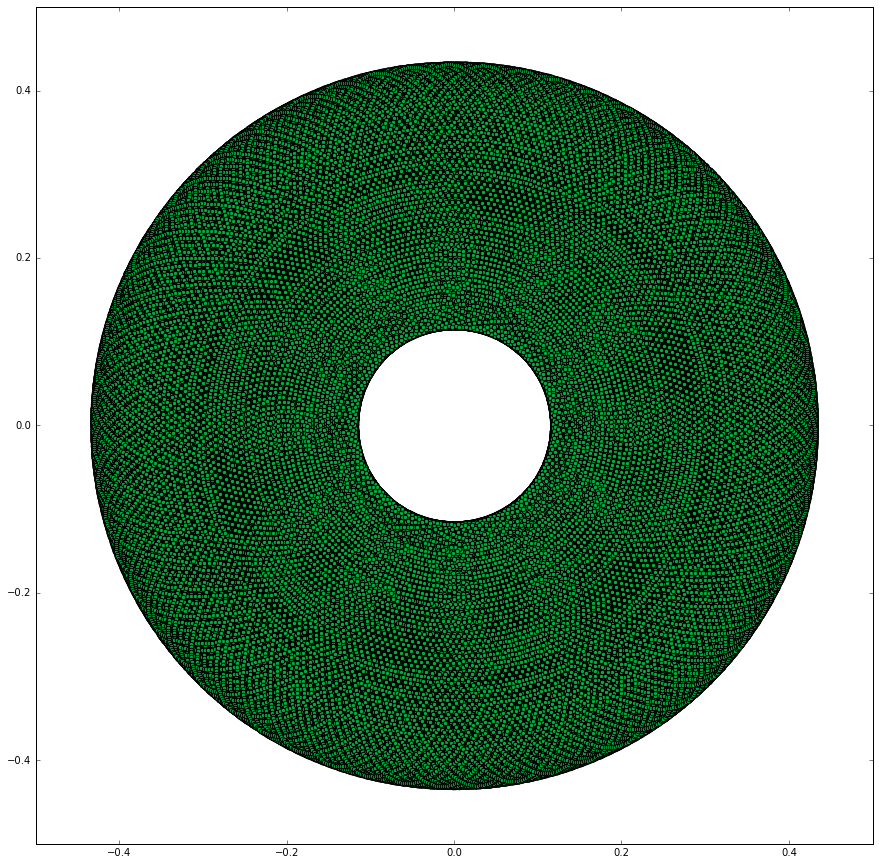

In [319]:
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
plt.scatter(xo[:], yo[:], c = 'crimson')
plt.scatter(xo1[:], yo1[:], c = 'blue')
plt.scatter(xo2[:], yo2[:], c = 'orange')
plt.scatter(xo3[:], yo3[:], c = '#00AF3F')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

(-0.3, 0.3)

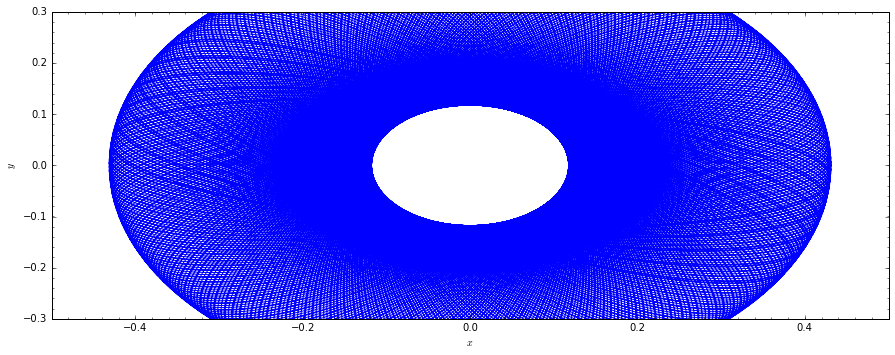

In [318]:
orb = Orbit(vxvv = [0.2,-.6,.5, 0.])
timespan = np.linspace(0,1000,30000)
orb.integrate(timespan, ps, method = 'leapfrog')
orb.plot(d1 = 'x', d2 = 'y')
plt.xlim(-0.5,0.5)
plt.ylim(-0.3,0.3)

(-0.5, 0.5)

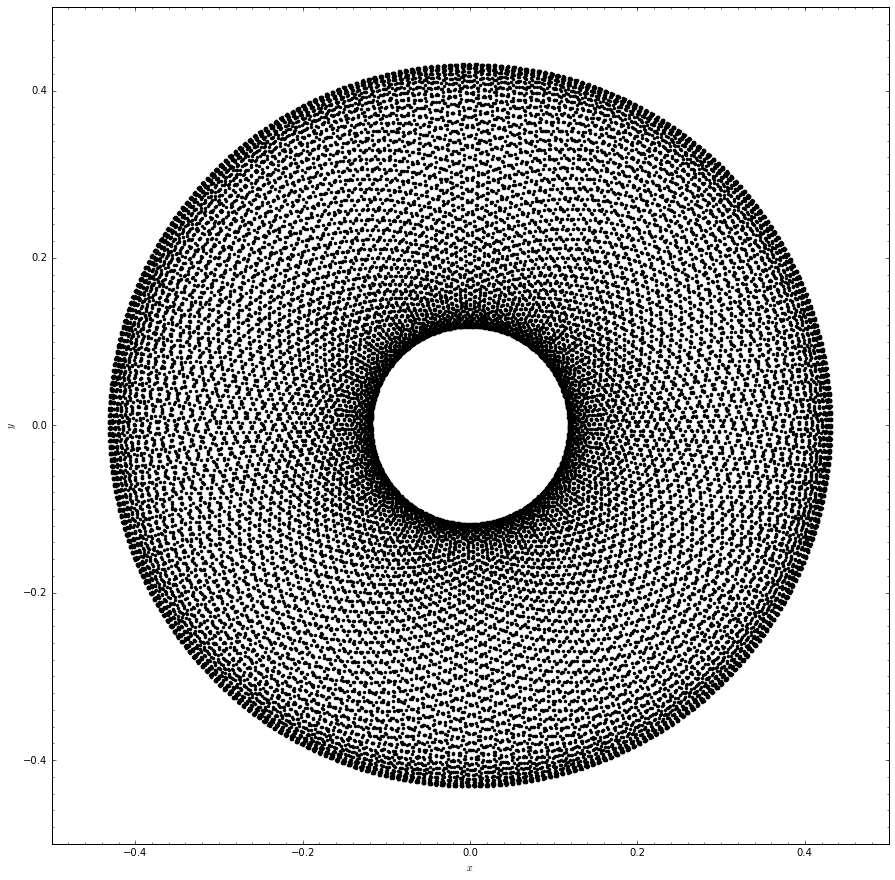

In [320]:
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
orb.plot('k.',d1 = 'x', d2 = 'y')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)

(-2.1, 3.1)

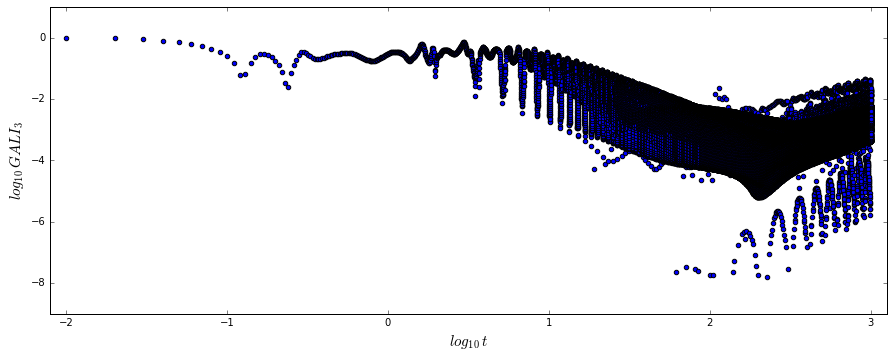

In [321]:
#pp = PP(normalize = True)
#icon = np.array([0.2,-.6,.5, 0.])
#results = galievol(icon, tau, ps, Tm, Gm)

matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter(np.log10(results[:,0]), np.log10(results[:,1]))
plt.xlabel(r'$log_{10}\,t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)
plt.xlim(-2.1,3.1)

(900, 1000)

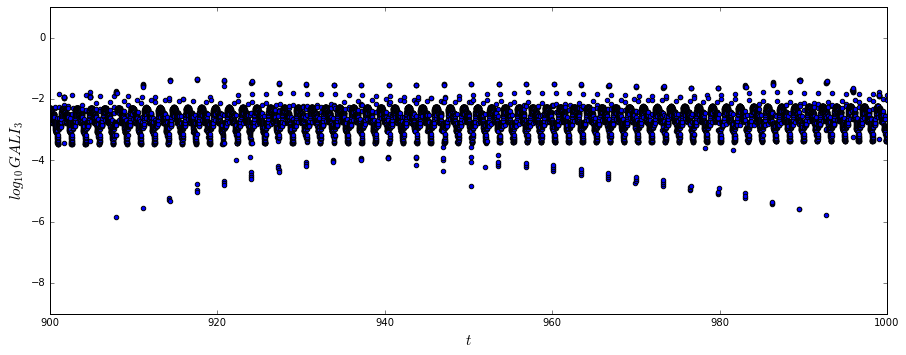

In [325]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter(results[:,0], np.log10(results[:,1]))
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)
plt.xlim(900,1000)

In [70]:
o = Orbit(vxvv = [1,0.25,0.7,0.0,0.0,0.0])
ts = np.linspace(0,10,100)
o.integrate(ts, ps, method = 'leapfrog')
#o1 = Orbit(vxvv = [0.2,-.6,.507, 0.])
#ts = np.linspace(0,5,100)
#o1.integrate(ts, ps, method = 'leapfrog')
#o2 = Orbit(vxvv = [0.2,-.606,.5, 0.])
#ts = np.linspace(0,5,100)
#o2.integrate(ts, ps, method = 'leapfrog')

In [331]:
def galievol(o,tau, potential, Tm, Gm):
    galis = np.zeros([1+int(Tm/tau),2]) # array large enough
    continuing = True # stopping flag
    i = 1 # counter
    w = None #initial setting
    while continuing:
        galis[i-1][1], newo, a, O,v = gali(o, tau, potential, w)
        galis[i-1][0] = tau*i
        if galis[i-1][1]<Gm:
            print('if this code works, the orbit is chaotic...which means it doesn\'t when testing an orbit in axisymmetric potential')
            continuing = False
            return galis[:i-1][:]
        if i*tau > Tm:
            print('time reached treshold, orbit is regular')
            continuing = False
            return galis[:][:]
        i += 1
        o = newo
        w = a

In [334]:
Tm=10.
tau = 10**-2
Gm = 10**-18
# regular orbit in Ferrers Potential
ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1,0.25,0.7,0.0,0.0,0.0])
results2 = galievol(icon, tau, pmw, Tm, Gm)

time reached treshold, orbit is regular


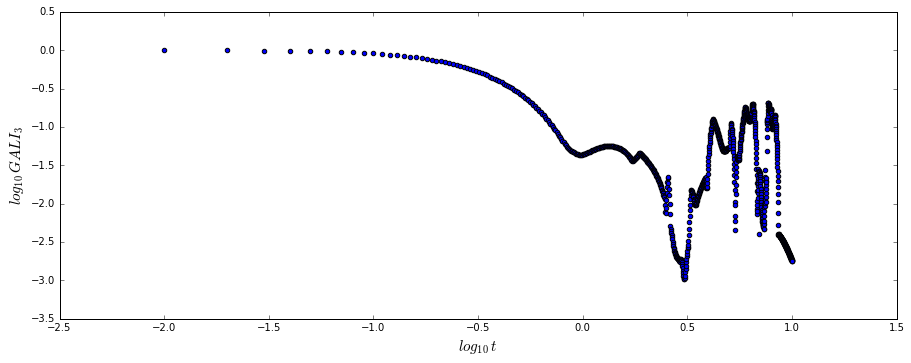

In [335]:
#icon = np.array([1,0.25,0.7,0.0,0.0,0.0])
#results2 = galievol(icon, tau, pmw, Tm, Gm)
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter(np.log10(results2[:,0]), np.log10(results2[:,1]))
plt.xlabel(r'$log_{10}\,t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)

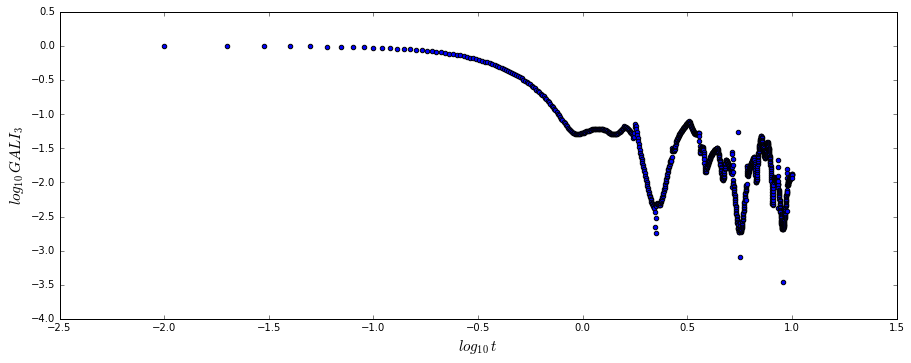

In [329]:
#icon = np.array([1,0.25,0.7,0.0,0.0,0.0])
#results3 = galievol(icon, tau, ps, Tm, Gm)
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter(np.log10(results3[:,0]), np.log10(results3[:,1]))
plt.xlabel(r'$log_{10}\,t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)

In [338]:
Tm=100.
tau = 10**-2
Gm = 10**-18
# orbit in rotating Ferrers Potential
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1,0.25,0.6,0,0.0,0])
results4 = galievol(icon, tau, pmw, Tm, Gm)

time reached treshold, orbit is regular


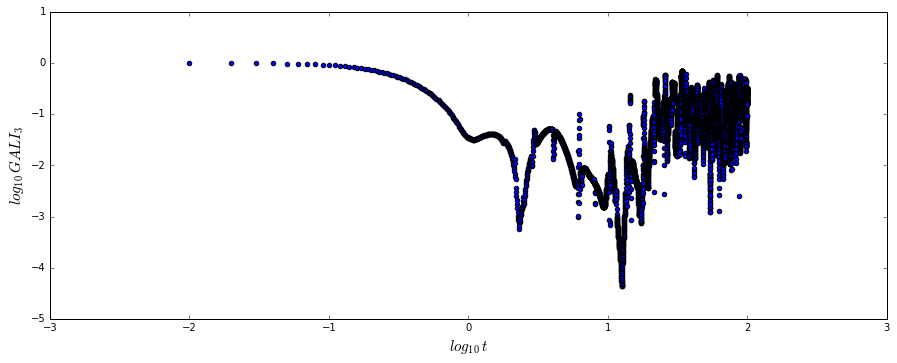

In [339]:
matplotlib.rcParams['figure.figsize'] = (15.0, 5.5)
plt.scatter(np.log10(results4[:,0]), np.log10(results4[:,1]))
plt.xlabel(r'$log_{10}\,t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)